# Object Detection API Demo

<table align="left"><td>
  <a target="_blank"  href="https://colab.sandbox.google.com/github/tensorflow/models/blob/master/research/object_detection/object_detection_tutorial.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab
  </a>
</td><td>
  <a target="_blank"  href="https://github.com/tensorflow/models/blob/master/research/object_detection/object_detection_tutorial.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td></table>

Welcome to the [Object Detection API](https://github.com/tensorflow/models/tree/master/research/object_detection). This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image.

> **Important**: This tutorial is to help you through the first step towards using [Object Detection API](https://github.com/tensorflow/models/tree/master/research/object_detection) to build models. If you just just need an off the shelf model that does the job, see the [TFHub object detection example](https://colab.sandbox.google.com/github/tensorflow/hub/blob/master/examples/colab/object_detection.ipynb).

# Setup

Important: If you're running on a local machine, be sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md). This notebook includes only what's necessary to run in Colab.

### Install

In [2]:
!pip install -U --pre tensorflow=="1.14"

Requirement already up-to-date: tensorflow==1.14 in /anaconda3/lib/python3.6/site-packages (1.14.0)


Make sure you have `pycocotools` installed

In [105]:
!pip install pycocotools

Get `tensorflow/models` or `cd` to parent directory of the repository.

In [3]:
import os
import pathlib

if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Compile protobufs and install the object_detection package

In [4]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.

object_detection/protos/input_reader.proto:5:1: warning: Import object_detection/protos/image_resizer.proto is unused.


In [3]:
%%bash 
cd models/research
pip install .

Processing /Users/DigitalDW/Desktop/Hearthstone_recognition/scripts/models/research
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1082501 sha256=71180c9609c5b2b3273c123ef779dfb20fbcbe6ac0f4e3bf7cd85f52aebe3ac1
  Stored in directory: /private/var/folders/hb/4w8hq0td22dfq8kvvnzxbsnh0000gn/T/pip-ephem-wheel-cache-zvbe96vv/wheels/87/1a/b7/85d3864bac67d06498f6556dd4e8d08757aa5a35c011a65377
Successfully built object-detection
  Attempting uninstall: object-detection
    Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1


### Imports

In [5]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

tf.compat.v1.enable_eager_execution()
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import display


/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

Import the object detection module.

In [6]:
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

Patches:

In [7]:
# patch tf1 into `utils.ops`
utils_ops.tf = tf.compat.v1

# Patch the location of gfile
tf.gfile = tf.io.gfile

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing the path.

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

## Loader

In [8]:
def load_model(model_name):
  base_url = './'
  model_dir = base_url + model_name + "/saved_model"

  model = tf.compat.v2.saved_model.load(model_dir, None)
  model = model.signatures['serving_default']

  return model

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [9]:
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = '../training/labelmap.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

For the sake of simplicity we will test on 2 images:

In [10]:
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = pathlib.Path('../images/trained')
TEST_IMAGE_PATHS = sorted(list(PATH_TO_TEST_IMAGES_DIR.glob("*.jpg")))
TEST_IMAGE_PATHS

[PosixPath('../images/trained/Stormpike-Commando-Hearthstone.jpg')]

# Detection

Load an object detection model:

In [12]:
model_name = 'hearthston_inference_graph_second_attempt'
detection_model = load_model(model_name)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Check the model's input signature, it expects a batch of 3-color images of type uint8: 

In [13]:
print(detection_model.inputs)

[<tf.Tensor 'image_tensor:0' shape=(?, ?, ?, 3) dtype=uint8>]


And returns several outputs:

In [14]:
detection_model.output_dtypes

{'raw_detection_boxes': tf.float32,
 'detection_scores': tf.float32,
 'raw_detection_scores': tf.float32,
 'detection_multiclass_scores': tf.float32,
 'detection_classes': tf.float32,
 'num_detections': tf.float32,
 'detection_boxes': tf.float32}

In [15]:
detection_model.output_shapes

{'raw_detection_boxes': TensorShape([Dimension(None), Dimension(300), Dimension(4)]),
 'detection_scores': TensorShape([Dimension(None), Dimension(300)]),
 'raw_detection_scores': TensorShape([Dimension(None), Dimension(300), Dimension(91)]),
 'detection_multiclass_scores': TensorShape([Dimension(None), Dimension(300), Dimension(91)]),
 'detection_classes': TensorShape([Dimension(None), Dimension(300)]),
 'num_detections': TensorShape([Dimension(None)]),
 'detection_boxes': TensorShape([Dimension(None), Dimension(300), Dimension(4)])}

Add a wrapper function to call the model, and cleanup the outputs:

In [16]:
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  output_dict = model(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  print(output_dict)
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

Run it on each test image and show the results:

In [17]:
def show_inference(model, image_path):
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  """image = Image.open(image_path)
  image.load()
  rbg_img = Image.new("RGB", (image.size[0], image.size[1]))
  rbg_img.paste(image, mask=image.split()[3])
  image_np = np.array(rbg_img)"""
  image_np = np.array(Image.open(image_path))
  # Actual detection.
  output_dict = run_inference_for_single_image(model, image_np)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8)

  display(Image.fromarray(image_np))

{'raw_detection_boxes': <tf.Tensor: id=15795, shape=(1, 300, 4), dtype=float32, numpy=
array([[[0.47710854, 0.37667274, 0.6606279 , 0.45735466],
        [0.4785039 , 0.52321565, 0.6753651 , 0.60459185],
        [0.47439963, 0.5957393 , 0.66399497, 0.6824165 ],
        ...,
        [0.01829145, 0.22915335, 0.15581107, 0.31501746],
        [0.17554592, 0.8867263 , 0.3757818 , 0.97118133],
        [0.05536554, 0.18078303, 0.46081194, 0.6575688 ]]], dtype=float32)>, 'detection_scores': <tf.Tensor: id=15793, shape=(1, 300), dtype=float32, numpy=
array([[7.36421585e-01, 2.15952456e-01, 1.77172586e-01, 1.53829679e-01,
        7.73636252e-02, 5.79618551e-02, 3.19949985e-02, 2.95017231e-02,
        2.47302633e-02, 2.09012050e-02, 1.26710180e-02, 1.11380080e-02,
        9.56214126e-03, 6.70441566e-03, 6.08750014e-03, 4.76254895e-03,
        4.43226704e-03, 3.98581475e-03, 3.71798873e-03, 3.56555753e-03,
        3.32589238e-03, 2.69170338e-03, 2.38317437e-03, 2.19731033e-03,
        2.03777500e-0

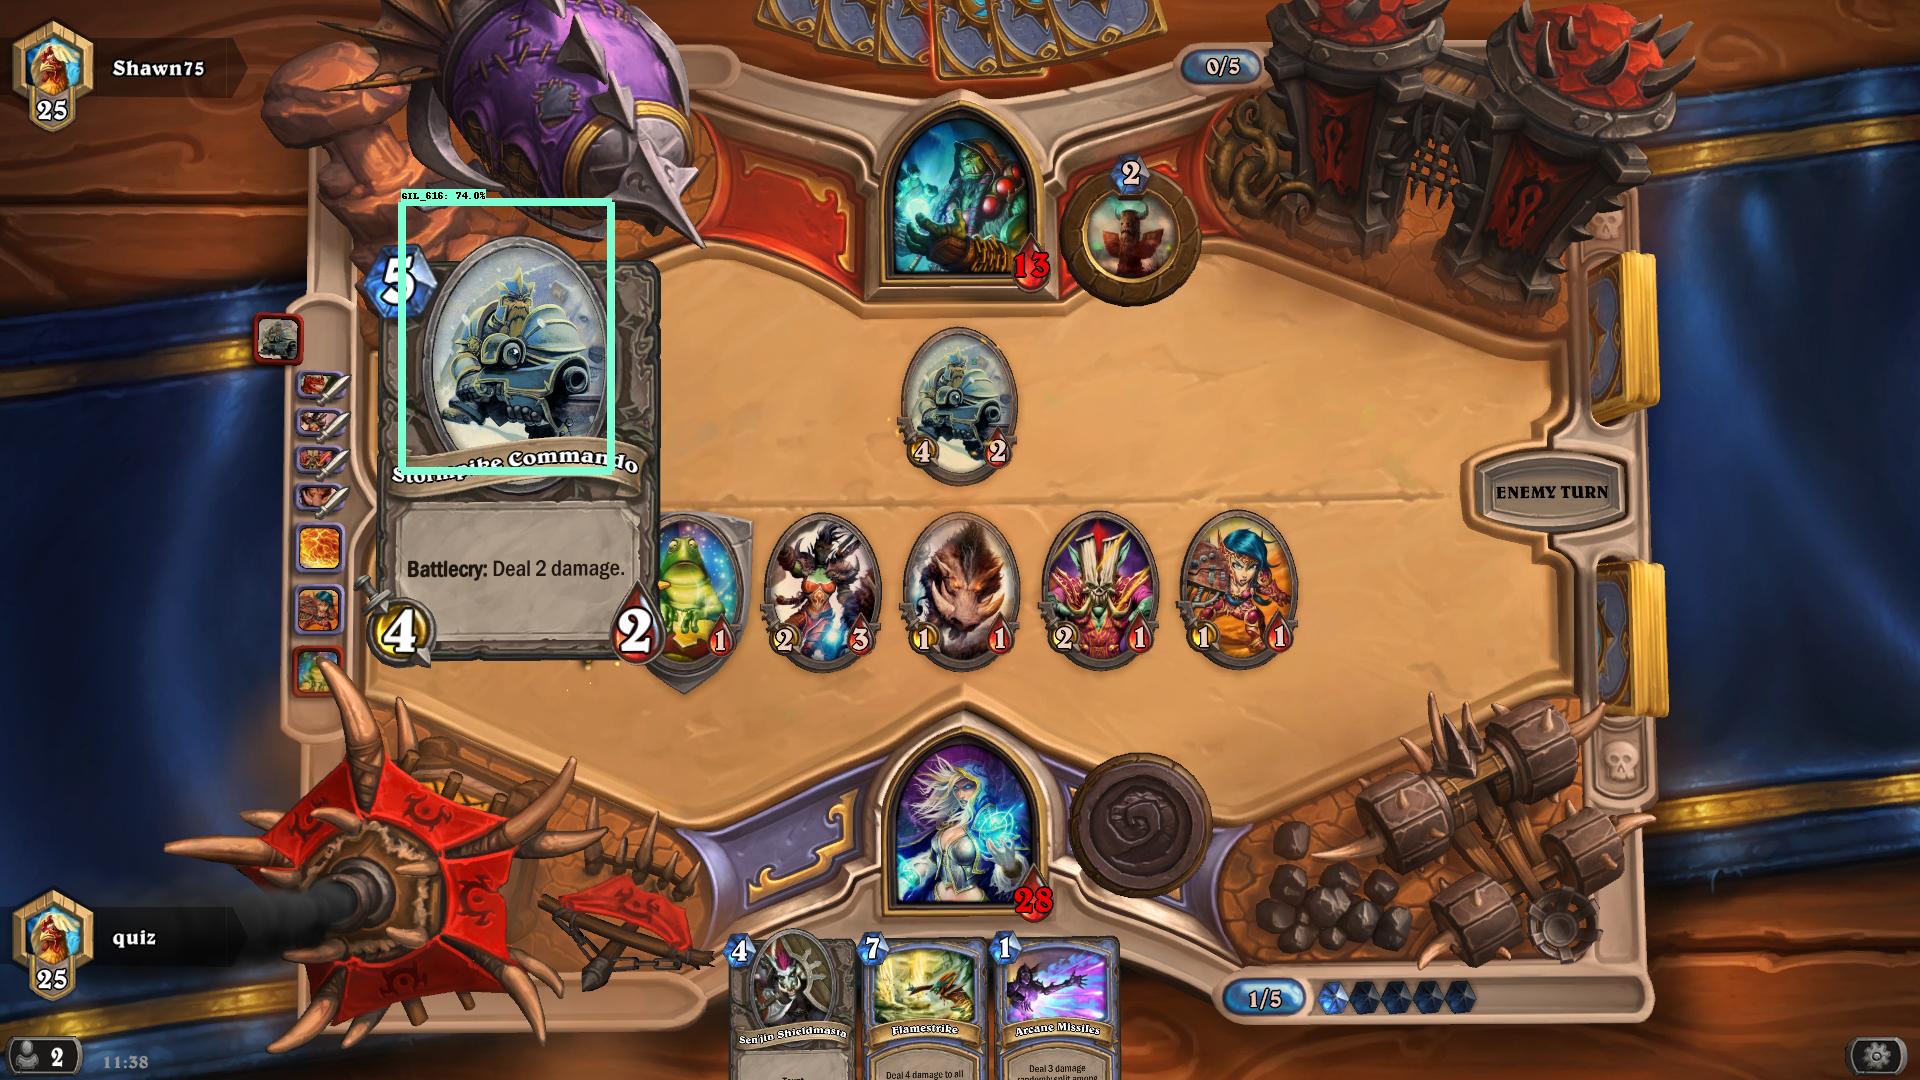

In [18]:
for image_path in TEST_IMAGE_PATHS:
  show_inference(detection_model, image_path)


## Instance Segmentation

In [0]:
model_name = "mask_rcnn_inception_resnet_v2_atrous_coco_2018_01_28"
masking_model = load_model(model_name)

The instance segmentation model includes a `detection_masks` output:

In [0]:
masking_model.output_shapes

In [0]:
for image_path in TEST_IMAGE_PATHS:
  show_inference(masking_model, image_path)